In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_lightning import seed_everything

seed_everything(12345)

/hdd1/aidml/sjwi/interactive-colorization/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 12345


12345

## Load Config & checkpoints

In [2]:
from omegaconf import OmegaConf
from interactive_coloring.pipeline import InteractiveColoringPipeLine

# load config file
config = OmegaConf.load('models/interactivce-coloring.yaml')

# Instantiate PipeLine from config
pipe = InteractiveColoringPipeLine.from_config(config)

# Load colorizer model checkpoints
pipe.colorizer.load_checkpoint(ldm_path="./models/anything-v3-full.safetensors",
                               cldm_path="./models/control_v11p_sd15s2_lineart_anime.pth")

ControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_

## Prepare Images

Succesfully set new lineart. # of Segmentation Regions: 74


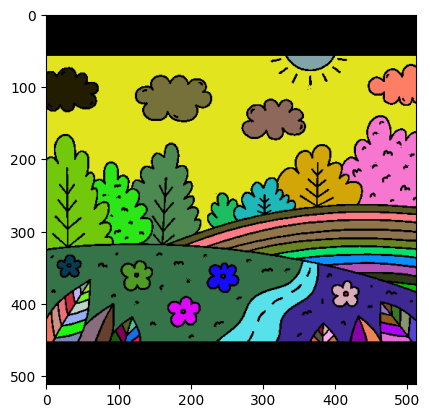

In [3]:
from utils import show_segmap

# load lineart
img = cv2.imread('./assets/lineart0.jpg')

# Set lineart. Pipe automatically preprocess lineart and generates segmentation map
# Provide exlanation of your lineart iamge. Longer description_prompt, higher colorization quality. 
pipe.set_lineart(img, description_prompt="nature scene, clouds, sky, grass, flower field, trees")

# Visualize generated segmentation map
show_segmap(pipe._segmentation_map)

## Colorization

Data shape for DDIM sampling is (1, 4, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


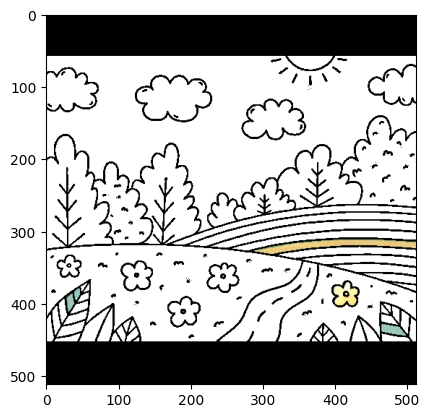

In [4]:
# Colorization by AI
# n_target: number of regions you want AI to color
output = pipe.robot_turn_coloring(n_target=pipe.num_regions // 10)
user_coloring = output.copy() # just for explanation
plt.imshow(output)

# If you like AI's coloring:
pipe.update_color(output)

# To send user's coloring to AI, use:
pipe.user_turn_coloring(user_coloring)

### Interactive Colorization

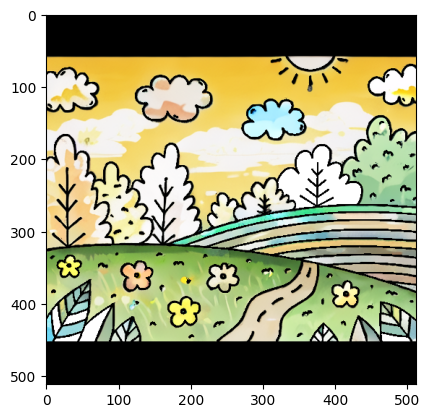

In [5]:
from IPython import display

outputs = []
# simulation of turn-based interactive colorization
for i in range(0, pipe.num_regions, pipe.num_regions//10):
    output = pipe.robot_turn_coloring(n_target=pipe.num_regions // 10)
    pipe.update_color(output)
    display.clear_output(wait=False)
    plt.imshow(output)
    display.display(plt.gcf())
    outputs.append(output)
display.clear_output(wait=False)

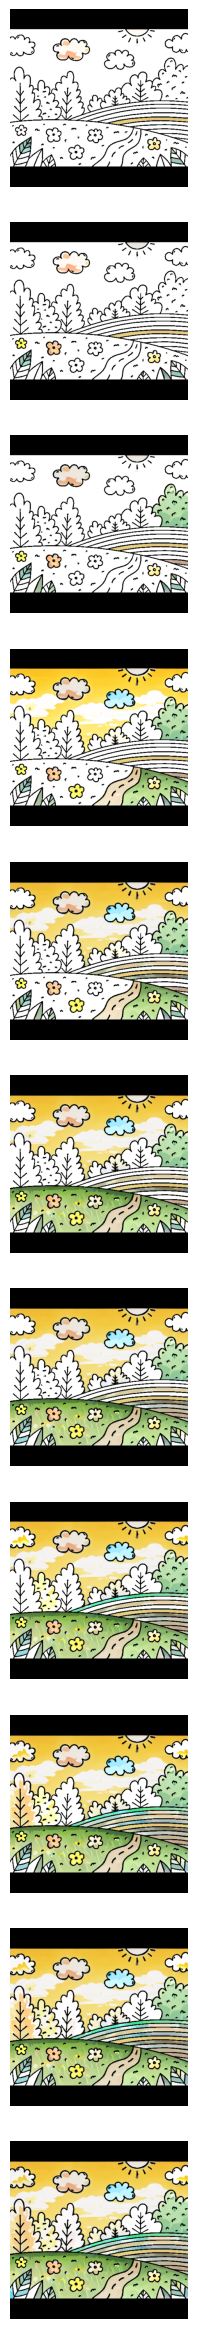

In [6]:
fig, axes = plt.subplots(len(outputs))
fig.set_size_inches(30, 30)
for i in range(len(outputs)):
    axes[i].imshow(outputs[i])
    axes[i].axis('off')